# ARIMA

## Membuka file Excel harga saham TLKM

In [1]:
# Membuka data

import pandas as pd
df = pd.read_excel('TLKM_Price.xlsx')

In [2]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2021-01-04 15:00:00', '2021-01-05 15:00:00',
               '2021-01-06 15:00:00', '2021-01-07 15:00:00',
               '2021-01-08 15:00:00', '2021-01-11 15:00:00',
               '2021-01-12 15:00:00', '2021-01-13 15:00:00',
               '2021-01-14 15:00:00', '2021-01-15 15:00:00',
               ...
               '2021-07-28 15:00:00', '2021-07-29 15:00:00',
               '2021-07-30 15:00:00', '2021-08-02 15:00:00',
               '2021-08-03 15:00:00', '2021-08-04 15:00:00',
               '2021-08-05 15:00:00', '2021-08-06 15:00:00',
               '2021-08-09 15:00:00', '2021-08-10 15:00:00'],
              dtype='datetime64[ns]', name='Date', length=148, freq=None)

In [3]:
df.head()

,Close
Date,
2021-01-04 15:00:00,3490
2021-01-05 15:00:00,3470
2021-01-06 15:00:00,3370
2021-01-07 15:00:00,3390
2021-01-08 15:00:00,3570


## Pengecekan Prasyarat Awal

### Rolling statistics

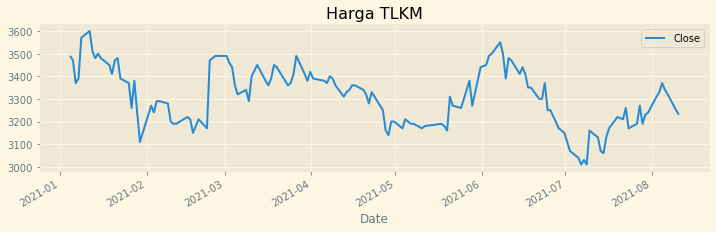

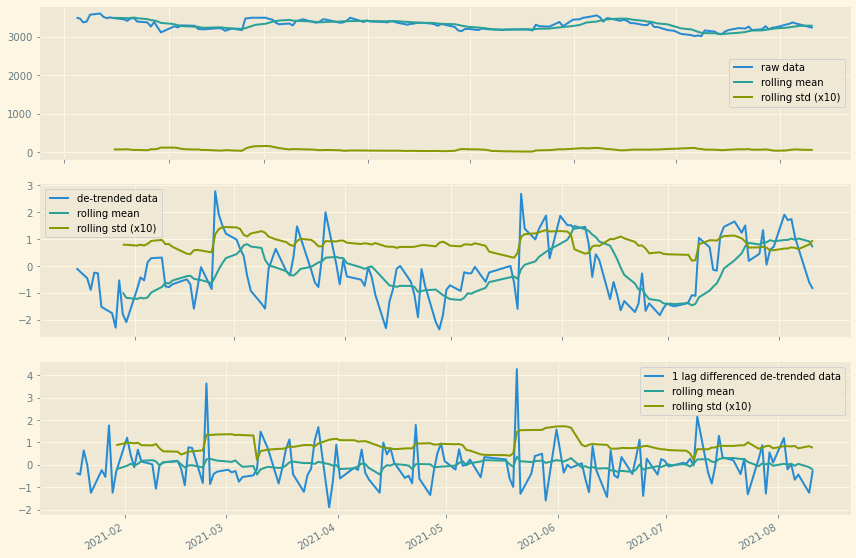

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('Solarize_Light2')

df.plot(figsize=(12,3));
plt.title('Harga TLKM');

df['harga_z'] = (df - df.rolling(window=10).mean()) / df.rolling(window=10).std()
df['harga_zp'] = df['harga_z'] - df['harga_z'].shift(1)

fig, ax = plt.subplots(3,figsize=(12, 9))
ax[0].plot(df.index, df['Close'], label='raw data')
ax[0].plot(df['Close'].rolling(window=10).mean(), label="rolling mean");
ax[0].plot(df['Close'].rolling(window=10).std(), label="rolling std (x10)");
ax[0].legend()

ax[1].plot(df.index, df['harga_z'], label="de-trended data")
ax[1].plot(df['harga_z'].rolling(window=10).mean(), label="rolling mean");
ax[1].plot(df['harga_z'].rolling(window=10).std(), label="rolling std (x10)");
ax[1].legend()

ax[2].plot(df.index, df['harga_zp'], label="1 lag differenced de-trended data")
ax[2].plot(df['harga_zp'].rolling(window=10).mean(), label="rolling mean");
ax[2].plot(df['harga_zp'].rolling(window=10).std(), label="rolling std (x10)");
ax[2].legend()

plt.tight_layout()
fig.autofmt_xdate()

### Augmented Dickey-Fuller Test

Cara membuat data menjadi stationer:
1. De-trending: menghilangkan tren dalam data, misalnya dengan membagi dengan deflator dalam data yang berkaitan dengan nilai mata uang atau melakukan scalling menggunakan z-score

2. Differencing: mengurangkan nilai dengan nilai sebelumnya dalam periode tertentu, untuk data yang mengandung seasonality dapat dilakukan dengan mengurangkan dengan nilai-lag dalam periode seasonality tersebut

3. Logging: menghilangkan exponential trend

In [5]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df['Close'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df['harga_z'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df['harga_zp'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -3.143
P-value = 0.024
Critical values :
	1%: -3.4756368462466662 - The data is not stationary with 99% confidence
	5%: -2.8814104466172608 - The data is  stationary with 95% confidence
	10%: -2.5773652982553568 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -4.985
P-value = 0.000
Critical values :
	1%: -3.47864788917503 - The data is  stationary with 99% confidence
	5%: -2.882721765644168 - The data is  stationary with 95% confidence
	10%: -2.578065326612056 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -11.501
P-value = 0.000
Critical values :
	1%: -3.4793722137854926 - The data is  stationary with 99% confidence
	5%: -2.8830370378332995 - The data is  stationary with 95% confidence
	10%: -2.578233635380623 - The data is  stationary with 90% confidence


### Decomposition

Memecah data time series menjadi 3 komponen:
1. trend
2. seasonal
3. residual

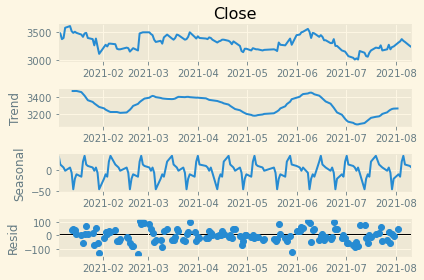

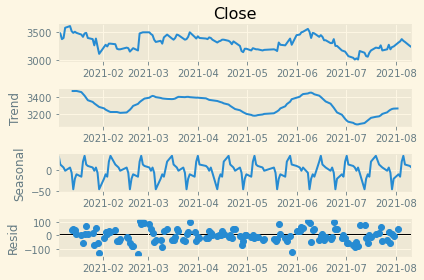

In [6]:
# Decomposition harga saham

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['Close'], period=12)
decomp.plot()

### Cek autocorrelation antara series dengan lag-nya

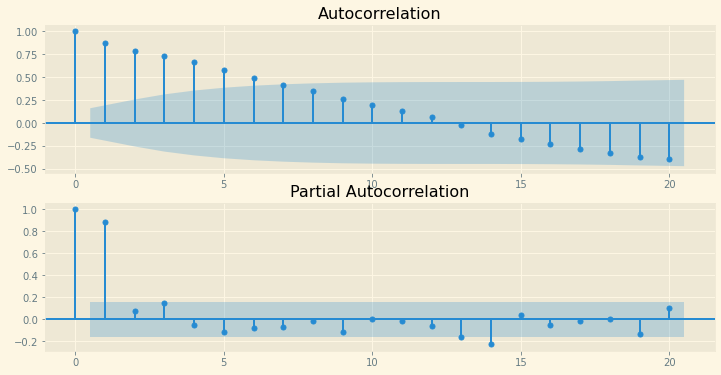

In [7]:
# Cek harga saham

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df['Close'].dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df['Close'].dropna(), ax=ax[1], lags=20)

Cara menentukan order dari ARIMA:
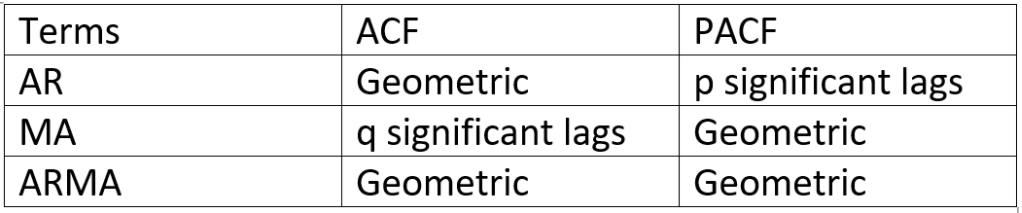

Sumber: https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8

## Forecasting dengan ARIMA

In [8]:
# Import numpy

import numpy as np

### Import ARIMA Model

C:\Users\arifudin.miftakhul\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\arifudin.miftakhul\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\arifudin.miftakhul\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\arifudin.miftakhul\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarnin

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  148
Model:                          ARIMA   Log Likelihood                -928.001
Date:                Thu, 12 Aug 2021   AIC                           1860.003
Time:                        18:18:41   BIC                           1865.997
Sample:                             0   HQIC                          1862.438
                                - 148                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3310.2027     10.604    312.174      0.000    3289.420    3330.986
sigma2      1.636e+04   2364.609      6.919      0.000    1.17e+04     2.1e+04
Ljung-Box (L1) (Q):                 115.80   Jarque-

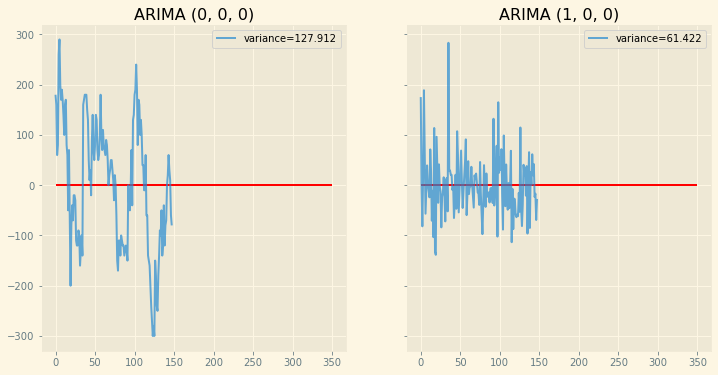

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Close'].dropna(), order=(0, 0, 0))
mod_000 = model.fit()
print(mod_000.summary())

model = ARIMA(df['Close'].dropna(), order=(1, 0, 0))
mod_100 = model.fit()
print(mod_100.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(mod_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(mod_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA (0, 0, 0)");
ax[0].legend();

ax[1].plot(mod_100.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(mod_100.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA (1, 0, 0)");
ax[1].legend();

### Ploting Prediction

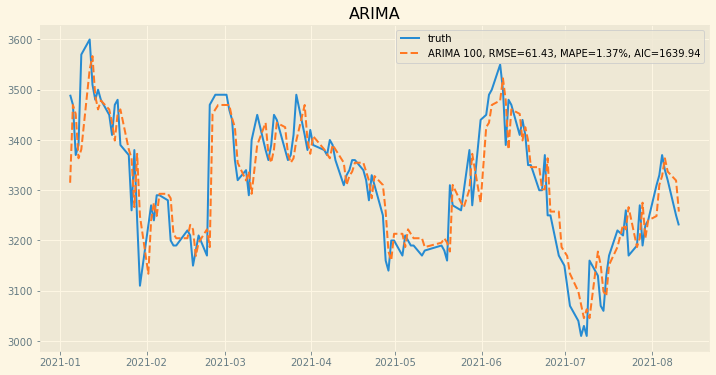

In [10]:
pred = mod_100.get_prediction(dynamic=False)
y_pred = pred.predicted_mean
sse = np.sqrt(np.mean(np.square(y_pred - df['Close'])))
mape = np.mean(np.abs((y_pred - df['Close'])/df['Close']))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['Close'], label='truth');
ax.plot(y_pred, linestyle='--', color='#ff7823', label="ARIMA 100, RMSE={:0.2f}, MAPE={:0.2f}%, AIC={:0.2f}".format(sse, mape*100, mod_100.aic));
ax.legend();
ax.set_title("ARIMA");

### Quality Metrics

Statistical information yang digunakan untuk melihat kualitas model forecasting di antaranya adalah:
1. RMSE: Root Mean Square Error
2. MAPE: Mean absolute percentage error
3. AIC: Akaike information criterion --> AIC dikembangkan oleh Hirotugu Akaike yang bertujuan untuk mencegah overfitting dengan lebih mengutamakan model yang simpel dibandingkan yang kompleks. 

Nilai yang lebih rendah mengindikasikan kualitas model yang lebih baik

MAPE:
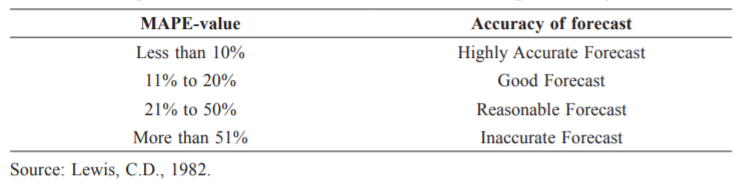

Sumber: Lewis (1982) dalam Kasemset, sae-haew, & Sopadang (2014)

#### Train-Test Split 

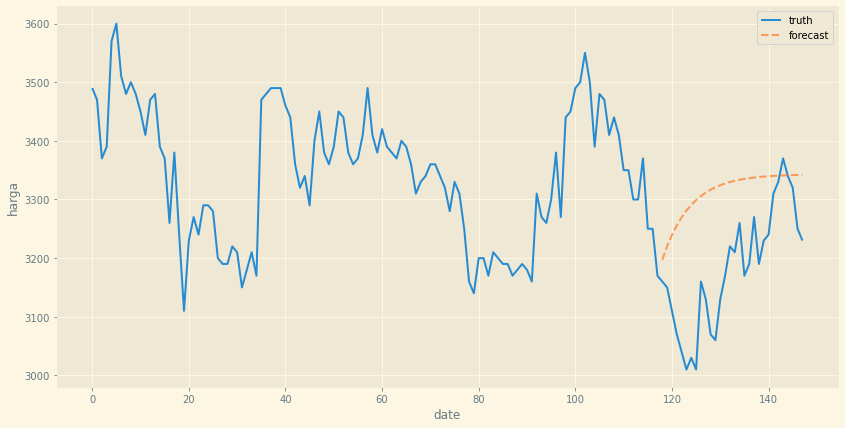

In [11]:
df2 = df.reset_index()

train_tlkm, test_tlkm = df2['Close'][0:-30], df2['Close'][-30:]

model_ev = ARIMA(train_tlkm.dropna(), order=(1, 0, 0))
mod_100_ev = model_ev.fit()
pred_ev = mod_100_ev.forecast(30)
ax = df2['Close'].plot(label='truth')
pred_ev.plot(linestyle='--', color='#ff7823', ax=ax, label='forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('date')
ax.set_ylabel('harga')
plt.legend()
plt.show()

In [12]:
# Quality Metrics

from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error

rmse = lambda act, pred: np.sqrt(mean_squared_error(act, pred))

print('RMSE: {:0.2f}'.format(rmse(test_tlkm, pred_ev)))
print('MAPE: {:0.2f}%'.format(mean_absolute_percentage_error(test_tlkm, pred_ev)*100))

RMSE: 156.36
MAPE: 4.27%


#### Multiple Train-Test Splits

Metode multiple train-test splits:
1. Sliding-windows

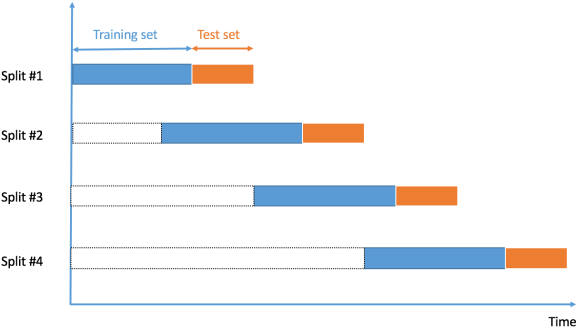

2. Expanding-windows
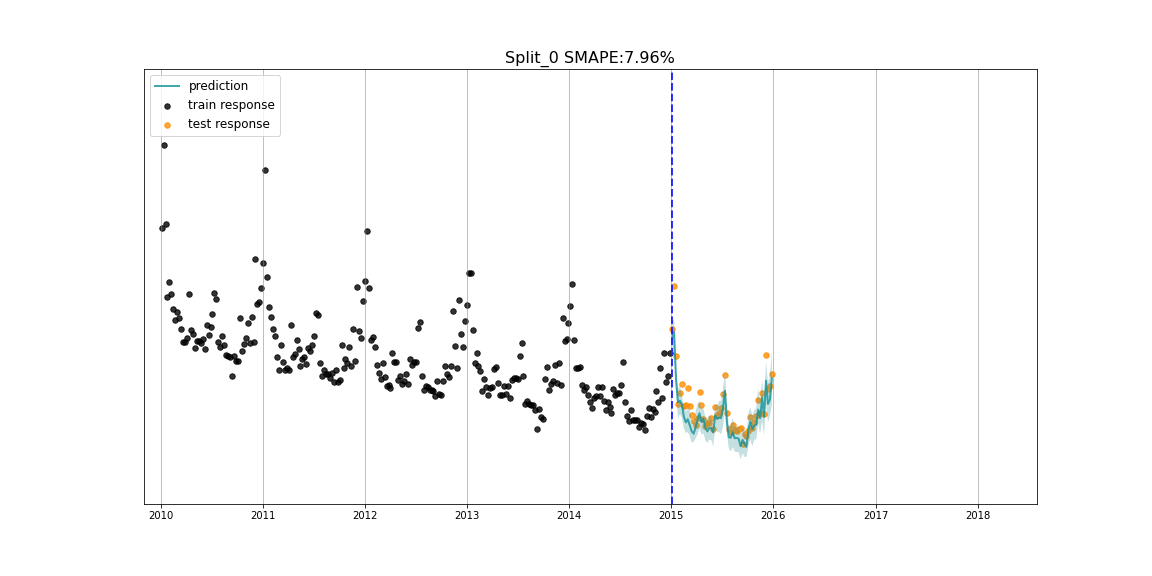

Sumber: https://eng.uber.com/orbit/ ; https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c

Observations: 74
Training Observations: 37
Testing Observations: 37
Observations: 111
Training Observations: 74
Testing Observations: 37
Observations: 148
Training Observations: 111
Testing Observations: 37


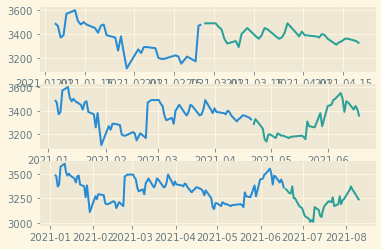

In [13]:
# Expanding Windows

from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

X = df['Close']
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train_tlkm_mul = X[train_index]
    test_tlkm_mul = X[test_index]
    print('Observations: %d' % (len(train_tlkm_mul) + len(test_tlkm_mul)))
    print('Training Observations: %d' % (len(train_tlkm_mul)))
    print('Testing Observations: %d' % (len(test_tlkm_mul)))
    pyplot.subplot(310 + index)
    pyplot.plot(train_tlkm_mul)
    pyplot.plot(test_tlkm_mul)
    index += 1
pyplot.show()

RMSE: 45.57
MAPE: 1.07%
RMSE: 132.71
MAPE: 3.57%
RMSE: 183.61
MAPE: 4.92%
RMSE_mean: 120.63
MAPE_mean: 3.19%


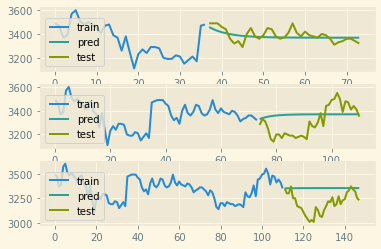

In [15]:
# Quality Metrics

df2 = df.reset_index()
X2 = df2['Close']
RMSE = []
MAPE = []

pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X2):
    train_tlkm_mul = X2[train_index]
    test_tlkm_mul = X2[test_index]
    model_mul = ARIMA(train_tlkm_mul.dropna(), order=(1, 0, 0))
    mod_100_mul = model_mul.fit()
    pred_tlkm_mul = mod_100_mul.forecast(len(test_tlkm_mul))
    
    RMSE.append(rmse(test_tlkm_mul, pred_tlkm_mul))
    MAPE.append(mean_absolute_percentage_error(test_tlkm_mul, pred_tlkm_mul))
    
    print('RMSE: {:0.2f}'.format(RMSE[index-1]))
    print('MAPE: {:0.2f}%'.format(MAPE[index-1]*100))
    pyplot.subplot(310 + index)
    pyplot.plot(train_tlkm_mul, label='train')
    pyplot.plot(pred_tlkm_mul, label='pred')
    pyplot.plot(test_tlkm_mul, label='test')
    pyplot.legend()
    index += 1
    
RMSE = np.mean(RMSE)
MAPE = np.mean(MAPE)
print('RMSE_mean: {:0.2f}'.format(RMSE))
print('MAPE_mean: {:0.2f}%'.format(MAPE*100))

### Forecasting

Proyeksi hari ke-1: 3240
Proyeksi hari ke-2: 3249
Proyeksi hari ke-3: 3256
Proyeksi hari ke-4: 3263
Proyeksi hari ke-5: 3269
Proyeksi hari ke-6: 3274
Proyeksi hari ke-7: 3279
Proyeksi hari ke-8: 3283
Proyeksi hari ke-9: 3287
Proyeksi hari ke-10: 3290
Proyeksi hari ke-11: 3293
Proyeksi hari ke-12: 3296
Proyeksi hari ke-13: 3298
Proyeksi hari ke-14: 3300
Proyeksi hari ke-15: 3302
Proyeksi hari ke-16: 3303
Proyeksi hari ke-17: 3304
Proyeksi hari ke-18: 3306
Proyeksi hari ke-19: 3307
Proyeksi hari ke-20: 3308
Proyeksi hari ke-21: 3309
Proyeksi hari ke-22: 3309
Proyeksi hari ke-23: 3310
Proyeksi hari ke-24: 3310
Proyeksi hari ke-25: 3311
Proyeksi hari ke-26: 3311
Proyeksi hari ke-27: 3312
Proyeksi hari ke-28: 3312
Proyeksi hari ke-29: 3313
Proyeksi hari ke-30: 3313


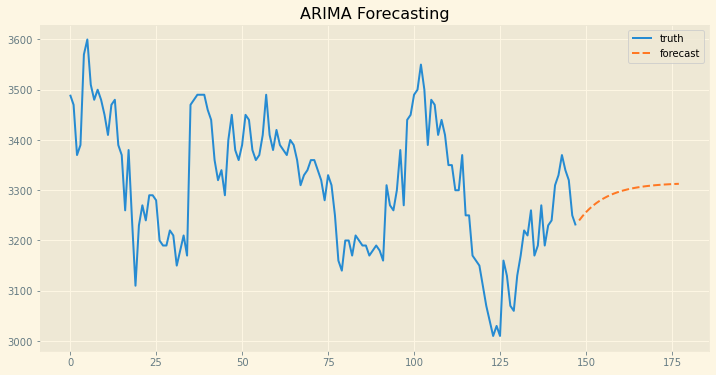

In [16]:
model_fc = ARIMA(df2['Close'].dropna(), order=(1, 0, 0))
result = model_fc.fit()

fc = result.forecast(30)
for i in range(30):
    print("Proyeksi hari ke-"+str(i+1)+": %.0f" % (fc[i:i+1]))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df2['Close'], label='truth');
ax.plot(fc, linestyle='--', color='#ff7823', label="forecast");
ax.legend();
ax.set_title("ARIMA Forecasting");

# SARIMA dan Exponential Smoothing

## Membuka file Excel realisasi APBD Bulanan

In [17]:
# Membuka data

import pandas as pd
apbd = pd.read_excel('APBD Series.xlsx')

In [18]:
# Preview data

apbd = apbd.set_index('Date')

apbd.head()

,Pendapatan,Belanja
Date,,
2018-01-01,7.217380e+13,2.449003e+13
2018-02-01,5.558584e+13,3.536379e+13
2018-03-01,8.138632e+13,5.384930e+13
2018-04-01,9.278896e+13,7.421715e+13
2018-05-01,7.798495e+13,8.418871e+13


## Pengecekan Prasyarat Awal

### Rolling statistics 

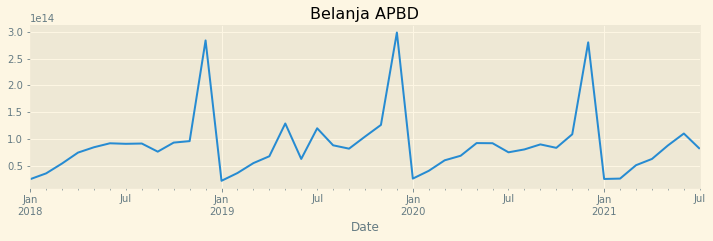

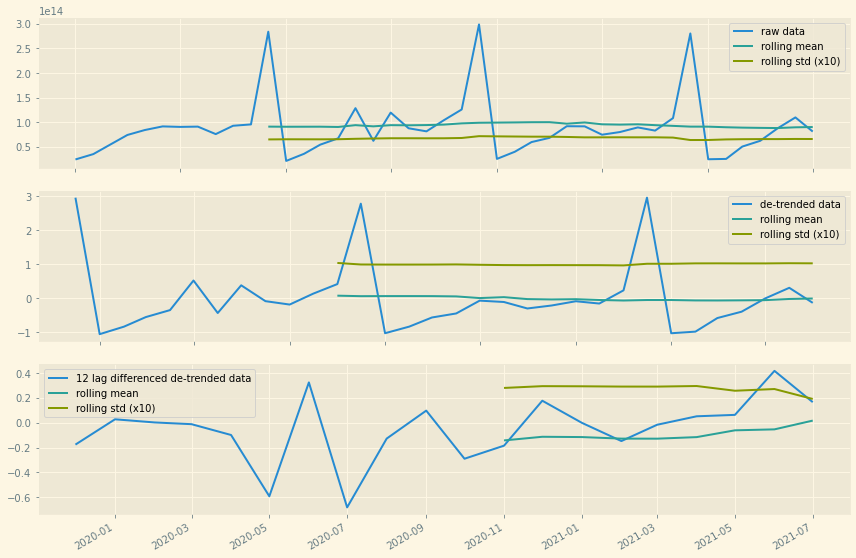

In [19]:
plt.style.use('Solarize_Light2')

apbd['Belanja'].plot(figsize=(12,3));
plt.title('Belanja APBD');

apbd['z_belanja'] = (apbd['Belanja'] - apbd['Belanja'].rolling(window=12).mean()) / apbd['Belanja'].rolling(window=12).std()
apbd['zp_belanja'] = apbd['z_belanja'] - apbd['z_belanja'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df['Belanja'], label='raw data')
    ax[0].plot(df['Belanja'].rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df['Belanja'].rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df['z_belanja'], label="de-trended data")
    ax[1].plot(df['z_belanja'].rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df['z_belanja'].rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df['zp_belanja'], label="12 lag differenced de-trended data")
    ax[2].plot(df['zp_belanja'].rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df['zp_belanja'].rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    
plot_rolling(apbd)

### Augmented Dickey-Fuller Test

In [20]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(apbd['Belanja'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(apbd.z_belanja.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(apbd.zp_belanja.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -6.563
P-value = 0.000
Critical values :
	1%: -3.596635636000432 - The data is  stationary with 99% confidence
	5%: -2.933297331821618 - The data is  stationary with 95% confidence
	10%: -2.6049909750566895 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.618
P-value = 0.000
Critical values :
	1%: -3.7883858816542486 - The data is  stationary with 99% confidence
	5%: -3.013097747543462 - The data is  stationary with 95% confidence
	10%: -2.6463967573696143 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -0.549
P-value = 0.882
Critical values :
	1%: -3.889265672705068 - The data is not stationary with 99% confidence
	5%: -3.0543579727254224 - The data is not stationary with 95% confidence
	10%: -2.66698384083045 - The data is not stationary with 90% confidence


### Decomposition 

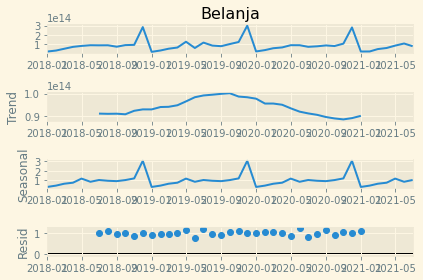

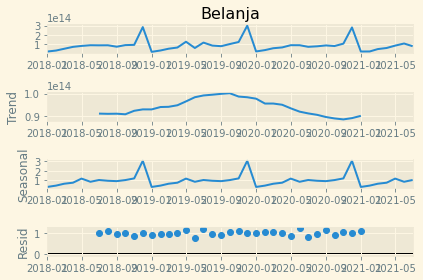

In [21]:
# Decomposition

decomp = seasonal_decompose(apbd['Belanja'], model='multiplicable', period=12)
decomp.plot()

## Forecasting dengan SARIMA

### Import SARIMA Model

In [22]:
import statsmodels.api as sm
import itertools
import warnings
import numpy as np

belanja = apbd['Belanja']

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(belanja,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue

mod = sm.tsa.statespace.SARIMAX(belanja,
                                order=best_result[0],
                                seasonal_order=best_result[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [23]:
# Model dengan AIC terendah

best_result

[(1, 1, 1), (0, 1, 1, 12), 1028.1203631312999]

### Ploting Prediction

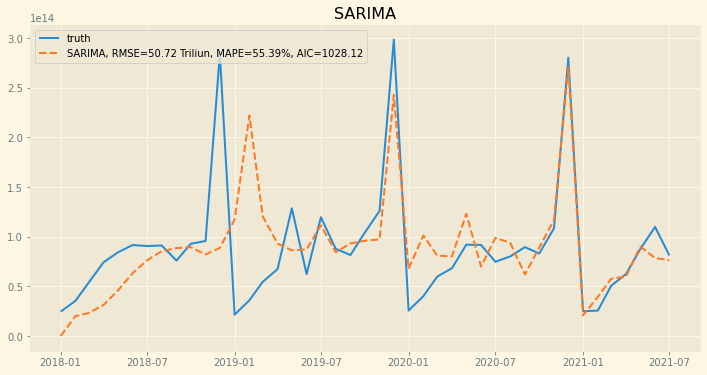

In [24]:
pred_sar = results.get_prediction(dynamic=False)
y_pred_sar = pred_sar.predicted_mean
sse = np.sqrt(np.mean(np.square(y_pred_sar - apbd['Belanja'])))
mape = np.mean(np.abs((y_pred_sar - apbd['Belanja'])/apbd['Belanja']))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(apbd['Belanja'], label='truth');
ax.plot(y_pred_sar, linestyle='--', color='#ff7823', label="SARIMA, RMSE={:0.2f} Triliun, MAPE={:0.2f}%, AIC={:0.2f}".format(sse/1000000000000, mape*100, results.aic));
ax.legend();
ax.set_title("SARIMA");

### Quality Metrics

#### Train-Test Split 

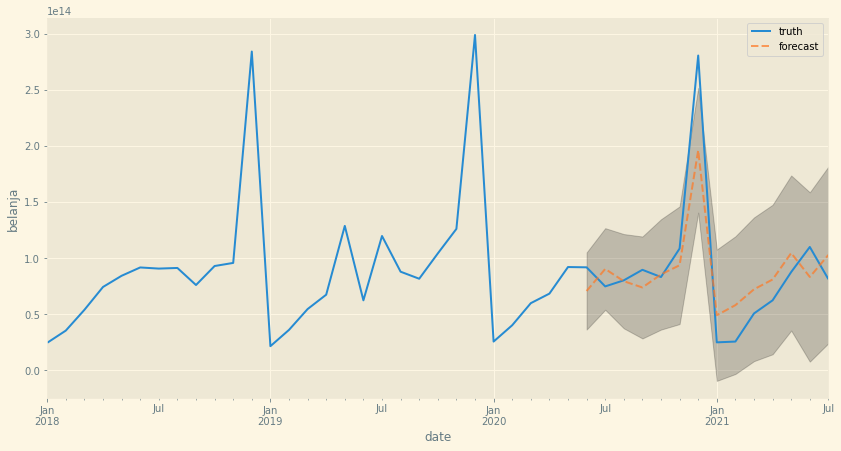

Proyeksi 2020-06-01 00:00:00: 70.62 Triliun
Proyeksi 2020-07-01 00:00:00: 90.26 Triliun
Proyeksi 2020-08-01 00:00:00: 79.36 Triliun
Proyeksi 2020-09-01 00:00:00: 73.76 Triliun
Proyeksi 2020-10-01 00:00:00: 85.39 Triliun
Proyeksi 2020-11-01 00:00:00: 93.58 Triliun
Proyeksi 2020-12-01 00:00:00: 195.98 Triliun
Proyeksi 2021-01-01 00:00:00: 49.04 Triliun
Proyeksi 2021-02-01 00:00:00: 58.04 Triliun
Proyeksi 2021-03-01 00:00:00: 72.16 Triliun
Proyeksi 2021-04-01 00:00:00: 80.86 Triliun
Proyeksi 2021-05-01 00:00:00: 104.46 Triliun


In [29]:
train_apbd, test_apbd = apbd['Belanja'][0:-14], apbd['Belanja'][-14:]

mod_ev = sm.tsa.statespace.SARIMAX(train_apbd,
                                order=best_result[0],
                                seasonal_order=best_result[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_ev = mod_ev.fit()

pred_sar_ev = results_ev.get_prediction(start=pd.to_datetime('2020-06-01'), end=pd.to_datetime('2021-07-01'), dynamic=False)
pred_sar_ci = pred_sar_ev.conf_int()
ax = apbd['Belanja'].plot(label='truth')
pred_sar_ev.predicted_mean.plot(linestyle='--', color='#ff7823', ax=ax, label='forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_sar_ci.index,
                pred_sar_ci.iloc[:, 0],
                pred_sar_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('belanja')
plt.legend()
plt.show()

forecast_ev = pred_sar_ev.predicted_mean
for i in range(12):
     print("Proyeksi "+str(pd.to_datetime('2020-06-01') + pd.DateOffset(months=i))+": %.2f Triliun" % (forecast_ev[i:i+1]/1000000000000))

In [30]:
# Quality Metrics

print('RMSE: {:0.2f} Triliun'.format(rmse(test_apbd, forecast_ev)/1000000000000))
print('MAPE: {:0.2f}%'.format(mean_absolute_percentage_error(test_apbd, forecast_ev)*100))

RMSE: 29.51 Triliun
MAPE: 33.95%


#### Multiple Train-Test Splits 

Observations: 29
Training Observations: 15
Testing Observations: 14
Observations: 43
Training Observations: 29
Testing Observations: 14


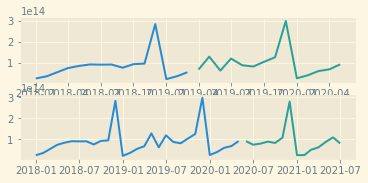

In [31]:
# Expanding Windows

X = apbd['Belanja']
splits = TimeSeriesSplit(n_splits=2)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train_apbd_mul = X[train_index]
    test_apbd_mul = X[test_index]
    print('Observations: %d' % (len(train_apbd_mul) + len(test_apbd_mul)))
    print('Training Observations: %d' % (len(train_apbd_mul)))
    print('Testing Observations: %d' % (len(test_apbd_mul)))
    pyplot.subplot(310 + index)
    pyplot.plot(train_apbd_mul)
    pyplot.plot(test_apbd_mul)
    index += 1
pyplot.show()

RMSE: 18.97 Triliun
MAPE: 15.23%
RMSE: 29.51 Triliun
MAPE: 33.95%
RMSE_mean: 24.24 Triliun
MAPE_mean: 24.59%


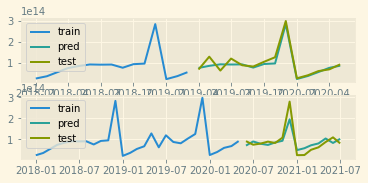

In [32]:
# Quality Metrics

RMSE = []
MAPE = []
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train_apbd_mul = X[train_index]
    test_apbd_mul = X[test_index]
    model_apbd_mul = sm.tsa.statespace.SARIMAX(train_apbd_mul,
                                order=best_result[0],
                                seasonal_order=best_result[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results_apbd_mul = model_apbd_mul.fit()
    pred_apbd_mul = results_apbd_mul.forecast(len(test_apbd_mul))
    
    RMSE.append(rmse(test_apbd_mul, pred_apbd_mul))
    MAPE.append(mean_absolute_percentage_error(test_apbd_mul, pred_apbd_mul))
    print('RMSE: {:0.2f} Triliun'.format(RMSE[index-1]/1000000000000))
    print('MAPE: {:0.2f}%'.format(MAPE[index-1]*100))
    
    pyplot.subplot(310 + index)
    pyplot.plot(train_apbd_mul, label='train')
    pyplot.plot(pred_apbd_mul, label='pred')
    pyplot.plot(test_apbd_mul, label='test')
    pyplot.legend()
    index += 1

RMSE = np.mean(RMSE)
MAPE = np.mean(MAPE)
print('RMSE_mean: {:0.2f} Triliun'.format(RMSE/1000000000000))
print('MAPE_mean: {:0.2f}%'.format(MAPE*100))

### Forecasting

Proyeksi bulan ke-8: 92.25 Triliun
Proyeksi bulan ke-9: 89.86 Triliun
Proyeksi bulan ke-10: 94.38 Triliun
Proyeksi bulan ke-11: 115.22 Triliun
Proyeksi bulan ke-12: 286.38 Triliun


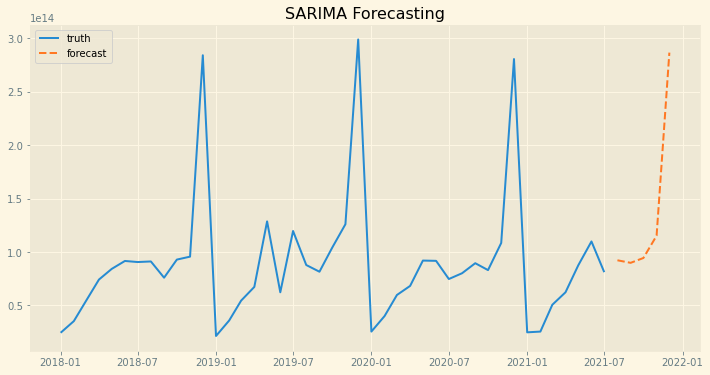

In [33]:
fc = results.forecast(5)
for i in range(5):
    print("Proyeksi bulan ke-"+str(i+8)+": %.2f Triliun" % (fc[i:i+1]/1000000000000))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(apbd['Belanja'], label='truth');
ax.plot(fc, linestyle='--', color='#ff7823', label="forecast");
ax.legend();
ax.set_title("SARIMA Forecasting");

## Forecasting dengan Exponential Smoothing

In [34]:
# Exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# membuat list untuk kombinasi option dari forecasting
tr = ['add', 'mul']
ss = ['add', 'mul']
dp = [True, False]
combs = {}
aics = []

# iterasi kombinasi option
for i in tr:
    for j in ss:
        for k in dp:
            model = ExponentialSmoothing(belanja, trend=i, seasonal=j, seasonal_periods=12, damped=k)
            model = model.fit()
            combs.update({model.aic : [i, j, k]})
            aics.append(model.aic)

# forecasting dengan kombinasi terbaik            
best_aic = min(aics)
model = ExponentialSmoothing(belanja, trend=combs[best_aic][0], seasonal=combs[best_aic][1], seasonal_periods=12, damped=combs[best_aic][2])
results_es = model.fit()

In [35]:
# Model dengan AIC terendah

combs[best_aic], best_aic

(['mul', 'add', False], 2627.8817973561313)

### Ploting Prediction

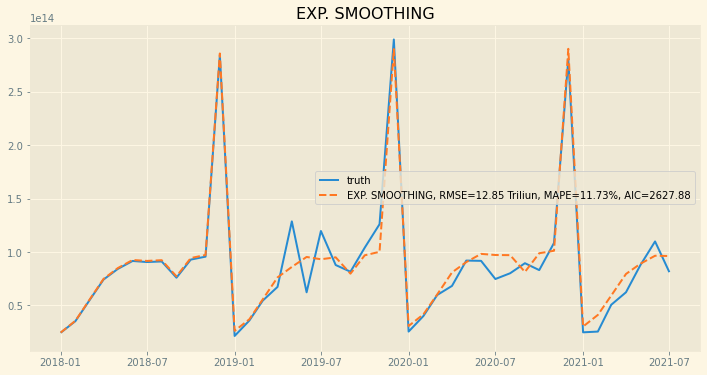

In [36]:
y_pred_es = results_es.predict(0,len(apbd['Belanja'])-1)
sse = np.sqrt(np.mean(np.square(y_pred_es - apbd['Belanja'])))
mape = np.mean(np.abs((y_pred_es - apbd['Belanja'])/apbd['Belanja']))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(apbd['Belanja'], label='truth');
ax.plot(y_pred_es, linestyle='--', color='#ff7823', label="EXP. SMOOTHING, RMSE={:0.2f} Triliun, MAPE={:0.2f}%, AIC={:0.2f}".format(sse/1000000000000, mape*100, results_es.aic));
ax.legend();
ax.set_title("EXP. SMOOTHING");

In [37]:
tabel = []
for i in tr:
    for j in ss:
        for k in dp:
            model = ExponentialSmoothing(belanja, trend=i, seasonal=j, seasonal_periods=12, damped=k)
            model = model.fit()
            pred = model.predict(0,len(belanja)-1)
            sse = np.sqrt(np.mean(np.square(pred - belanja)))
            mape = np.mean(np.abs((pred - belanja)/belanja))
            lst = [i, j, k, model.aic, "{:0.2f} Triliun".format(sse/1000000000000), "{:0.2f}%".format(mape*100)]
            tabel.append(lst)

In [38]:
ev_table = pd.DataFrame(tabel, columns=['trend','seasonality','damped','AIC','RMSE (Triliun)','MAPE (%)'])
ev_table

,trend,seasonality,damped,AIC,RMSE (Triliun),MAPE (%)
0,add,add,True,2631.239702,13.06 Triliun,12.61%
1,add,add,False,2629.580386,13.11 Triliun,12.76%
2,add,mul,True,2639.054937,14.30 Triliun,12.21%
3,add,mul,False,2637.646524,14.40 Triliun,11.83%
4,mul,add,True,2628.572185,15.39 Triliun,17.83%
5,mul,add,False,2627.881797,12.85 Triliun,11.73%
6,mul,mul,True,2633.770835,14.24 Triliun,12.41%
7,mul,mul,False,2632.324468,13.54 Triliun,10.82%


### Quality Metrics

#### Train-Test Split 

Proyeksi 2020-06-01 00:00:00: 94.85 Triliun
Proyeksi 2020-07-01 00:00:00: 98.18 Triliun
Proyeksi 2020-08-01 00:00:00: 96.61 Triliun
Proyeksi 2020-09-01 00:00:00: 82.24 Triliun
Proyeksi 2020-10-01 00:00:00: 99.74 Triliun
Proyeksi 2020-11-01 00:00:00: 104.04 Triliun
Proyeksi 2020-12-01 00:00:00: 291.40 Triliun
Proyeksi 2021-01-01 00:00:00: 30.96 Triliun
Proyeksi 2021-02-01 00:00:00: 42.51 Triliun
Proyeksi 2021-03-01 00:00:00: 61.27 Triliun
Proyeksi 2021-04-01 00:00:00: 80.47 Triliun
Proyeksi 2021-05-01 00:00:00: 95.03 Triliun


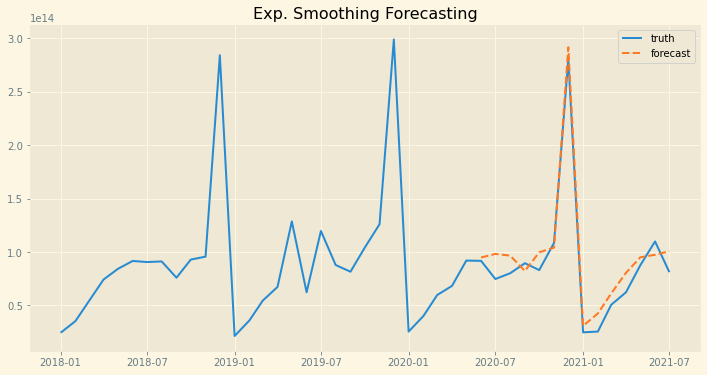

In [42]:
model_ev = ExponentialSmoothing(train_apbd, trend=combs[best_aic][0], seasonal=combs[best_aic][1], seasonal_periods=12, damped=combs[best_aic][2])
results_es_ev = model_ev.fit()

forecast_es_ev = results_es_ev.forecast(14)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(apbd['Belanja'], label='truth');
ax.plot(forecast_es_ev, linestyle='--', color='#ff7823', label="forecast");
ax.legend();
ax.set_title("Exp. Smoothing Forecasting");

for i in range(12):
     print("Proyeksi "+str(pd.to_datetime('2020-06-01') + pd.DateOffset(months=i))+": %.2f Triliun" % (forecast_es_ev[i:i+1]/1000000000000))

In [43]:
# Quality Metrics

print('RMSE: {:0.2f} Triliun'.format(rmse(test_apbd, forecast_es_ev)/1000000000000))
print('MAPE: {:0.2f}%'.format(mean_absolute_percentage_error(test_apbd, forecast_es_ev)*100))

RMSE: 13.80 Triliun
MAPE: 19.73%


#### Multiple Train-Test Splits 

RMSE: 18.25 Triliun
MAPE: 16.17%
RMSE: 13.80 Triliun
MAPE: 19.73%
RMSE_mean: 16.02 Triliun
MAPE_mean: 17.95%


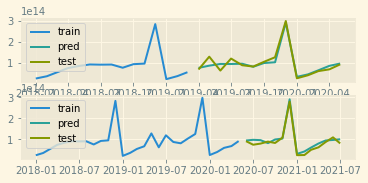

In [44]:
# Quality Metrics

RMSE = []
MAPE = []
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train_es_mul = X[train_index]
    test_es_mul = X[test_index]
    model_es_mul = ExponentialSmoothing(train_es_mul, trend=combs[best_aic][0], seasonal=combs[best_aic][1], seasonal_periods=12, damped=combs[best_aic][2])
    results_es_mul = model_es_mul.fit()
    pred_es_mul = results_es_mul.forecast(len(test_es_mul))
    
    RMSE.append(rmse(test_es_mul, pred_es_mul))
    MAPE.append(mean_absolute_percentage_error(test_es_mul, pred_es_mul))
    print('RMSE: {:0.2f} Triliun'.format(RMSE[index-1]/1000000000000))
    print('MAPE: {:0.2f}%'.format(MAPE[index-1]*100))
    
    pyplot.subplot(310 + index)
    pyplot.plot(train_es_mul, label='train')
    pyplot.plot(pred_es_mul, label='pred')
    pyplot.plot(test_es_mul, label='test')
    pyplot.legend()
    index += 1

RMSE = np.mean(RMSE)
MAPE = np.mean(MAPE)
print('RMSE_mean: {:0.2f} Triliun'.format(RMSE/1000000000000))
print('MAPE_mean: {:0.2f}%'.format(MAPE*100))

### Forecasting 

Proyeksi bulan ke-8: 96.37 Triliun
Proyeksi bulan ke-9: 81.39 Triliun
Proyeksi bulan ke-10: 98.51 Triliun
Proyeksi bulan ke-11: 101.48 Triliun
Proyeksi bulan ke-12: 289.97 Triliun


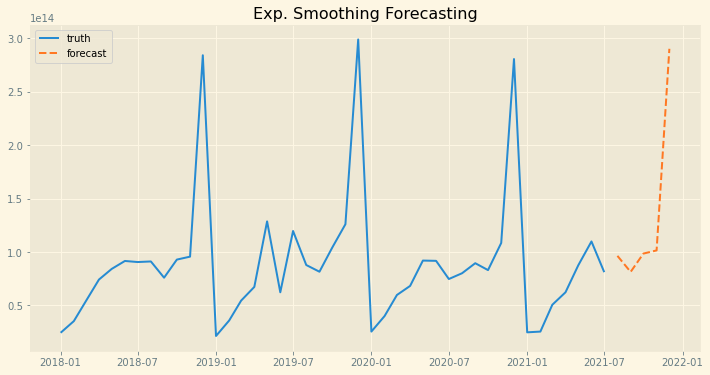

In [45]:
fc_es = results_es.forecast(5)
for i in range(5):
    print("Proyeksi bulan ke-"+str(i+8)+": %.2f Triliun" % (fc_es[i:i+1]/1000000000000))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(apbd['Belanja'], label='truth');
ax.plot(fc_es, linestyle='--', color='#ff7823', label="forecast");
ax.legend();
ax.set_title("Exp. Smoothing Forecasting");